In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

In [ ]:
#drive mount for dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#extracting data set file
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
#dataset
ds_asl_dir = "/tmp/asl_dataset/asl_dataset"
asl_ds = tf.keras.preprocessing.image_dataset_from_directory(ds_asl_dir)

Found 2515 files belonging to 36 classes.


Data Preliminary Exploration


In [ ]:
pd.DataFrame(asl_ds.class_names)

,0
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [ ]:
#Checking images and labels shapes (amount of images, height, width, color channels)
for image_batch, labels_batch in asl_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


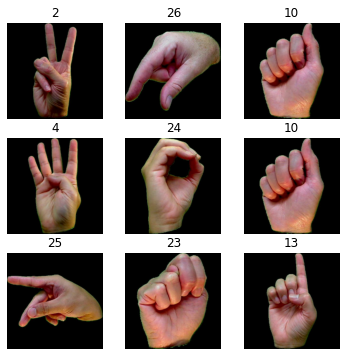

In [ ]:
#Displaying image samples
plt.figure(figsize=(6, 6))
for images, labels in asl_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
#Defining parameters for the loader

batch_size = 32
img_height = 64
img_width = 64

#Filtering out corrupted images

import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(ds_asl_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

#Augmenting the images

from keras.preprocessing.image import ImageDataGenerator
data_augmentation = ImageDataGenerator(rotation_range=15, rescale=1/255, zoom_range=0.1, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2)

#Setting train/test split

asl_train_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width), class_mode="categorical", batch_size=batch_size, subset="training")
asl_test_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width), class_mode="categorical", batch_size=batch_size, subset="validation")

Deleted 0 images
Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


In [ ]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense

'''Checking if the data format i.e the RGB channel is coming first or last so,
 whatever it may be, model will check first and then input shape will be feeded accordingly.'''

from keras import backend as K
if K.image_data_format() == "channels_first":
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

#Creating a model

model_dl = keras.Sequential()
model_dl.add(Conv2D(16,(3,3),activation="relu",input_shape=(input_shape)))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(32,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(64,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Flatten())
model_dl.add(Dense(128,activation="relu"))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(36,activation="softmax"))

In [ ]:
#Compiling the neural network

model_dl.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

#Fitting to the model

from keras.callbacks import EarlyStopping,ReduceLROnPlateau #Import callback functions
earlystop=EarlyStopping(patience=10) #Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor="val_accuracy",min_lr=0.001) #Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

model_dl.fit(asl_train_ds, validation_data=asl_test_ds, callbacks=callbacks, epochs=40)

Epoch 1/40
63/63 [==============================] - 17s 250ms/step - loss: 3.4838 - accuracy: 0.0527 - val_loss: 3.1833 - val_accuracy: 0.0934 - lr: 0.0010
Epoch 2/40
63/63 [==============================] - 14s 223ms/step - loss: 2.9145 - accuracy: 0.1501 - val_loss: 2.6298 - val_accuracy: 0.2644 - lr: 0.0010
Epoch 3/40
63/63 [==============================] - 14s 224ms/step - loss: 2.3602 - accuracy: 0.2634 - val_loss: 2.0416 - val_accuracy: 0.3618 - lr: 0.0010
Epoch 4/40
63/63 [==============================] - 14s 228ms/step - loss: 1.9539 - accuracy: 0.3623 - val_loss: 1.5900 - val_accuracy: 0.4692 - lr: 0.0010
Epoch 5/40
63/63 [==============================] - 14s 226ms/step - loss: 1.7181 - accuracy: 0.4314 - val_loss: 1.4183 - val_accuracy: 0.5487 - lr: 0.0010
Epoch 6/40
63/63 [==============================] - 14s 224ms/step - loss: 1.4820 - accuracy: 0.4861 - val_loss: 1.2293 - val_accuracy: 0.6024 - lr: 0.0010
Epoch 7/40
63/63 [==============================] - 14s 225ms/st

In [ ]:
#Saving the model

model_dl.save("model_dl.h5")

#Loading themodel

model_dl = keras.models.load_model("model_dl.h5") #look for local saved file

In [ ]:
#We´ll use any image sample from the Kaggle dataset to test it 

from keras.preprocessing import image

#Creating a dictionary to map each of the indexes to the corresponding number or letter

dict = {0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9",10:"a",11:"b",12:"c",13:"d",14:"e",15:"f",16:"g",
        17:"h",18:"i",19:"j",20:"k",21:"l",22:"m",23:"n",24:"o",25:"p",26:"q",27:"r",28:"s",29:"t",30:"u",31:"v",32:"w",
        33:"x",34:"y",35:"z"}

#Predicting images

img = image.load_img("/content/hand1_g_bot_seg_1_cropped.jpeg", target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = np.argmax(model_dl.predict(x), axis=-1)
probabilities = model_dl.predict(image, batch_size=batch_size)
probabilities_formatted = list(map("{:.2f}%".format, probabilities[0]*100))

print(classes) #displaying matrix prediction position

print(f'The predicted image corresponds to "{dict[classes.item()]}"') #displaying matrix prediction position name (number or letter)

[16]
The predicted image corresponds to "g"
